In [1]:
import time
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import dgl
import networkx as nx
import torch
import torch.nn as nn

import utils
from gsp_utils.baselines_archs import GCNN_2L
from gsp_utils.baselines_models import NodeClassModel, GF_NodeClassModel
from gsp_utils.data import normalize_gso
from src.arch import GFGCN, GFGCNLayer, GFGCN_noh_Layer, GFGCN_Spows

SEED = 15
# PATH = 'results/diff_filters/'
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(SEED)

cpu


In [2]:
# Auxiliary functions
def summary_table(acc, index_name):
    mean_accs = acc.mean(axis=1)
    med_accs = np.median(acc, axis=1)
    std_accs = acc.std(axis=1)
    return DataFrame(np.vstack((mean_accs, med_accs, std_accs)).T, columns=['mean accs', 'med', 'std'], index=index_name)

In [3]:
# Auxiliary functions
def compute_S_pows(S, K, device):
    N = S.shape[0]
    S_pows = torch.Tensor(torch.empty(K-1, N, N)).to(device)
    S_pows[0,:,:] = torch.Tensor(S).to(device)
    for k in range(1,K-1):
        S_pows[k,:,:] = S_pows[0,:,:] @ S_pows[k-1,:,:]

    return S_pows

In [4]:
# Dataset must be from DGL
dataset_name = 'WisconsinDataset'

A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device,
                                                     verb=True)
N = A.shape[0]

Dataset: WisconsinDataset
Number of nodes: 251
Number of features: 1703
Shape of signals: torch.Size([251, 1703])
Number of classes: 5
Norm of A: 22.69361114501953
Max value of A: 1.0
Proportion of validation data: 0.32
Proportion of test data: 0.20
Node homophily: 0.13
Edge homophily: 0.20


In [5]:
# BEST PARAMETERS
## Reaining params
N_RUNS = 20
N_EPOCHS = 200  # 5000
EPOCHS_h = 25 # 5 # 5
EPOCHS_W = 25 # 5 # 25
LR = .005
WD = .001  # .001
DROPOUT = .25

# BEST PARAMETERS
## Architecture params
N_LAYERS = 3
K = 2
HID_DIM = 50 # 100

## Model params
NORM = True

IN_DIM = feat.shape[1]
OUT_DIM = n_class

ACT = nn.LeakyReLU()  # nn.ELU()
LAST_ACT = nn.Softmax()
LOSS_FN = nn.CrossEntropyLoss()  # nn.CrossEntropyLoss()

## Plotting eval/test acc/loss

In [6]:
# Parameters
epochs = N_EPOCHS
epochs_h = EPOCHS_h
epochs_W = EPOCHS_W
lr = LR
wd = WD
drop = DROPOUT
L = N_LAYERS
K_aux = K
hid_dim = HID_DIM
norm = True
act = ACT
lact = LAST_ACT
loss_fn = LOSS_FN
bias = True
patience = 200

iters_aux = 1

err1 = np.zeros(iters_aux)
err2 = np.zeros(iters_aux)
for i in range(iters_aux):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)

    arch = GFGCN_Spows(IN_DIM, hid_dim, OUT_DIM, L, K_aux, act=act, last_act=lact,
                dropout=drop, norm=norm, bias=bias, dev=device)
    S = torch.Tensor(A).to(device)
    model = GF_NodeClassModel(arch, S, K_aux, masks, loss_fn, device=device)
    loss, acc = model.train(feat, labels, epochs, lr, wd, epochs_h=epochs_h, epochs_W=epochs_W,
                            patience=patience)

    idx_max_acc = np.argmax(acc["val"])
    print(f'Test acc at best val: {acc["test"][idx_max_acc]:.3f}  -  Best test acc: {np.max(acc["test"]):.3f}')
    acc_val = model.test(feat, model.S, labels, masks['val'])
    acc_test = model.test(feat, model.S, labels, masks['test'])
    print(f'Test acc (based on loss): {acc_test:.3f}')

    err1[i] = acc["test"][idx_max_acc]
    err2[i] = acc_test

/home/srey/Investigacion/robust_minmax_gnn/src/arch.py:189: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.last_act(X)


Test acc at best val: 0.804  -  Best test acc: 0.863
Test acc (based on loss): 0.824


Acc at best val acc: 0.804 +- 0.000
Acc at test: 0.824 +- 0.000


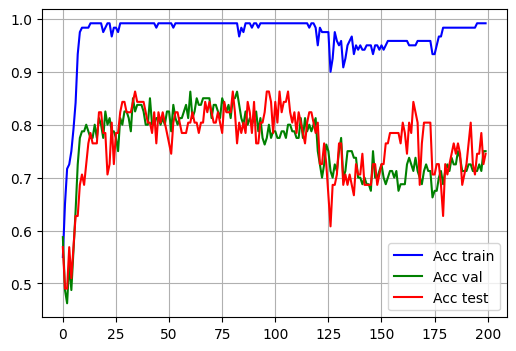

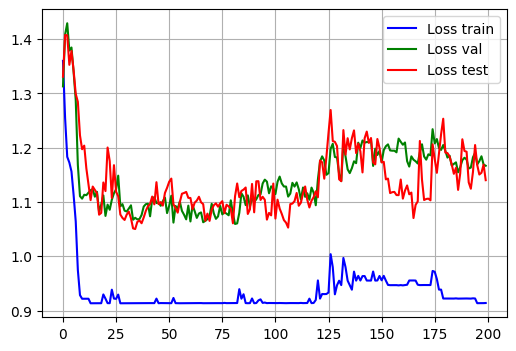

In [7]:
print(f'Acc at best val acc: {err1.mean():.3f} +- {err1.std():.3f}')
print(f'Acc at test: {err2.mean():.3f} +- {err1.std():.3f}')

# Plot
plt.figure(figsize=[6,4])
plt.plot(acc['train'], 'b-', label='Acc train')
plt.plot(acc['val'], 'g-', label='Acc val')
plt.plot(acc['test'], 'r-', label='Acc test')
plt.grid()
plt.legend()

plt.figure(figsize=[6,4])
plt.plot(loss['train'], 'b-', label='Loss train')
plt.plot(loss['val'], 'g-', label='Loss val')
plt.plot(loss['test'], 'r-', label='Loss test')
plt.grid()
plt.legend()

## Training paramerters

In [8]:
EXPS = [
        {'epochs': 200, 'lr': .005, 'wd': 1e-4, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 5e-4, 'drop': .25},

        {'epochs': 200, 'lr': .01, 'wd': 1e-3, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 1e-3, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 1e-3, 'drop': .5},
        {'epochs': 200, 'lr': .001, 'wd': 1e-3, 'drop': .25},

        {'epochs': 200, 'lr': .05, 'wd': 5e-3, 'drop': .25},
        {'epochs': 200, 'lr': .01, 'wd': 5e-3, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 5e-3, 'drop': .25},
        {'epochs': 200, 'lr': .001, 'wd': 5e-3, 'drop': .25},
        
        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 1e-2, 'drop': .25},

        # {'epochs': 500, 'lr': .01, 'wd': 1e-3, 'drop': .25},
        # {'epochs': 500, 'lr': .005, 'wd': 1e-3, 'drop': .25},
        # {'epochs': 500, 'lr': .001, 'wd': 1e-3, 'drop': .25},

        # {'epochs': 500, 'lr': .01, 'wd': 5e-3, 'drop': .25},
        # {'epochs': 500, 'lr': .005, 'wd': 5e-3, 'drop': .25},
        # {'epochs': 500, 'lr': .001, 'wd': 5e-3, 'drop': .25},


        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': .5},
        {'epochs': 200, 'lr': .05, 'wd': 5e-3, 'drop': .5},
        {'epochs': 200, 'lr': .01, 'wd': 5e-3, 'drop': .5},
        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': 0},
        {'epochs': 200, 'lr': .05, 'wd': 5e-3, 'drop': 0},
        {'epochs': 200, 'lr': .01, 'wd': 5e-3, 'drop': 0},

        
        # {'epochs': 500, 'lr': .005, 'wd': 5e-3, 'drop': .5},
        {'epochs': 500, 'lr': .005, 'wd': 1e-3, 'drop': .5},
        # {'epochs': 500, 'lr': .001, 'wd': 1e-3, 'drop': .5},

        # {'epochs': 750, 'lr': .005, 'wd': 5e-3, 'drop': .25},
        # {'epochs': 750, 'lr': .001, 'wd': 5e-3, 'drop': .25},
        # {'epochs': 750, 'lr': .001, 'wd': 1e-3, 'drop': .25},
        ]

best_accs1 = np.zeros((len(EXPS), N_RUNS))
best_val_accs1 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):        
        arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                           dropout=exp['drop'], norm=NORM, dev=device)
        S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, exp['epochs'], exp['lr'], exp['wd'],
                             epochs_h=EPOCHS_h, epochs_W=EPOCHS_W)

        best_accs1[j,i] = np.max(acc["test"])
        best_val_accs1[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}: {best_val_accs1[j,i]:.3f} ({best_accs1[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}' for exp in EXPS]
table_over1 = summary_table(best_accs1, index_name)
table1 = summary_table(best_val_accs1, index_name)

-1: 200-0.005-0.0001-0.25: 0.843 (0.882)
-1: 200-0.005-0.0005-0.25: 0.745 (0.882)
-1: 200-0.01-0.001-0.25: 0.843 (0.882)
-1: 200-0.005-0.001-0.25: 0.804 (0.863)
-1: 200-0.005-0.001-0.5: 0.824 (0.863)
-1: 200-0.001-0.001-0.25: 0.725 (0.863)
-1: 200-0.05-0.005-0.25: 0.725 (0.725)
-1: 200-0.01-0.005-0.25: 0.784 (0.863)
-1: 200-0.005-0.005-0.25: 0.843 (0.863)
-1: 200-0.001-0.005-0.25: 0.804 (0.824)
-1: 200-0.05-0.01-0.25: 0.745 (0.784)
-1: 200-0.005-0.01-0.25: 0.824 (0.863)
-1: 200-0.05-0.01-0.5: 0.824 (0.824)
-1: 200-0.05-0.005-0.5: 0.765 (0.843)
-1: 200-0.01-0.005-0.5: 0.843 (0.863)
-1: 200-0.05-0.01-0: 0.549 (0.725)
-1: 200-0.05-0.005-0: 0.627 (0.804)
-1: 200-0.01-0.005-0: 0.765 (0.843)
-1: 500-0.005-0.001-0.5: 0.804 (0.882)
-2: 200-0.005-0.0001-0.25: 0.843 (0.922)
-2: 200-0.005-0.0005-0.25: 0.843 (0.922)
-2: 200-0.01-0.001-0.25: 0.824 (0.922)
-2: 200-0.005-0.001-0.25: 0.843 (0.922)
-2: 200-0.005-0.001-0.5: 0.843 (0.922)
-2: 200-0.001-0.001-0.25: 0.902 (0.922)
-2: 200-0.05-0.005-0.25: 0

In [9]:
table1

,mean accs,med,std
200-0.005-0.0001-0.25,0.850000,0.843137,0.035226
200-0.005-0.0005-0.25,0.845098,0.852941,0.052941
200-0.01-0.001-0.25,0.822549,0.813725,0.053868
200-0.005-0.001-0.25,0.849020,0.843137,0.037767
200-0.005-0.001-0.5,0.860784,0.852941,0.040136
200-0.001-0.001-0.25,0.837255,0.862745,0.048069
200-0.05-0.005-0.25,0.768627,0.784314,0.076596
200-0.01-0.005-0.25,0.842157,0.843137,0.035875
200-0.005-0.005-0.25,0.854902,0.862745,0.036892
200-0.001-0.005-0.25,0.821569,0.813725,0.038172


In [10]:
table_over1

,mean accs,med,std
200-0.005-0.0001-0.25,0.910784,0.921569,0.025168
200-0.005-0.0005-0.25,0.913725,0.921569,0.026597
200-0.01-0.001-0.25,0.900000,0.901961,0.038172
200-0.005-0.001-0.25,0.908824,0.911765,0.026507
200-0.005-0.001-0.5,0.908824,0.911765,0.029264
200-0.001-0.001-0.25,0.884314,0.892157,0.034467
200-0.05-0.005-0.25,0.801961,0.823529,0.084768
200-0.01-0.005-0.25,0.885294,0.882353,0.029914
200-0.005-0.005-0.25,0.889216,0.892157,0.029914
200-0.001-0.005-0.25,0.868627,0.882353,0.026380


## Model params

In [11]:
# h0, norm (norm, not norm, norm H), sep vs joint training, optimizers iters (W vs h)
EXPS = [
        {'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},        
        {'epochs': 1000, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},

        {'epochs': 200, 'epochs_h': 5, 'epochs_W': 1, 'alt': True},
        {'epochs': 200, 'epochs_h': 10, 'epochs_W': 1, 'alt': True},
        {'epochs': 200, 'epochs_h': 25, 'epochs_W': 1, 'alt': True},
        {'epochs': 200, 'epochs_h': 25, 'epochs_W': 5, 'alt': True},

        {'epochs': 5000, 'epochs_h': 5, 'epochs_W': 1, 'alt': True},

        {'epochs': 50, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'epochs': 50, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},
        {'epochs': 100, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'epochs': 100, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},

        {'epochs': 200, 'epochs_h': 1, 'epochs_W': 5, 'alt': True},
        {'epochs': 200, 'epochs_h': 1, 'epochs_W': 10, 'alt': True},
        {'epochs': 200, 'epochs_h': 1, 'epochs_W': 25, 'alt': True},
        {'epochs': 200, 'epochs_h': 5, 'epochs_W': 25, 'alt': True},

        {'epochs': 100, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'epochs': 100, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},
        {'epochs': 200, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'epochs': 200, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},
        {'epochs': 200, 'epochs_h': 50, 'epochs_W': 50, 'alt': True},
        {'epochs': 500, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        ]


best_accs2 = np.zeros((len(EXPS), N_RUNS))
best_val_accs2 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                           dropout=DROPOUT, norm=NORM, dev=device)
        S = torch.Tensor(A).to(device)

        if not exp['alt']:
            S_pows = compute_S_pows(A, K, device)
            model = NodeClassModel(arch, S_pows, masks, LOSS_FN, device=device)
            _, acc = model.train(feat, labels, exp['epochs'], LR, WD)
        else:
            model = GF_NodeClassModel(arch, S,  K, masks, LOSS_FN, device=device)
            _, acc = model.train(feat, labels, exp['epochs'], LR, WD, epochs_h=exp['epochs_h'],
                                 epochs_W=exp['epochs_W'])

        best_accs2[j,i] = np.max(acc["test"])
        best_val_accs2[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["epochs_h"]}-{exp["epochs_W"]}-{exp["alt"]}: {best_val_accs2[j,i]:.3f} ({best_accs2[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["epochs_h"]}-{exp["epochs_W"]}-{exp["alt"]}' for exp in EXPS]
table_over2 = summary_table(best_accs2, index_name)
table2 = summary_table(best_val_accs2, index_name)

/home/srey/Investigacion/robust_minmax_gnn/src/arch.py:189: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.last_act(X)


-1: 1-1-True: 0.490 (0.549)
-1: 1-1-False: 0.804 (0.863)
-1: 5-1-True: 0.784 (0.824)
-1: 10-1-True: 0.784 (0.824)
-1: 25-1-True: 0.804 (0.824)
-1: 25-5-True: 0.745 (0.843)
-1: 5-1-True: 0.784 (0.843)
-1: 10-10-True: 0.745 (0.824)
-1: 25-25-True: 0.824 (0.863)
-1: 10-10-True: 0.804 (0.843)
-1: 25-25-True: 0.784 (0.882)
-1: 1-5-True: 0.451 (0.569)
-1: 1-10-True: 0.490 (0.588)
-1: 1-25-True: 0.588 (0.588)
-1: 5-25-True: 0.784 (0.863)
-1: 10-10-True: 0.804 (0.863)
-1: 25-25-True: 0.784 (0.843)
-1: 10-10-True: 0.784 (0.863)
-1: 25-25-True: 0.765 (0.882)
-1: 50-50-True: 0.804 (0.863)
-1: 10-10-True: 0.824 (0.863)
-2: 1-1-True: 0.608 (0.627)
-2: 1-1-False: 0.686 (0.706)
-2: 5-1-True: 0.863 (0.902)
-2: 10-1-True: 0.882 (0.882)
-2: 25-1-True: 0.843 (0.902)
-2: 25-5-True: 0.863 (0.922)
-2: 5-1-True: 0.627 (0.627)
-2: 10-10-True: 0.902 (0.922)
-2: 25-25-True: 0.863 (0.902)
-2: 10-10-True: 0.843 (0.922)
-2: 25-25-True: 0.863 (0.902)
-2: 1-5-True: 0.549 (0.627)
-2: 1-10-True: 0.569 (0.667)
-2: 1-25

In [ ]:
table2

,mean accs,med,std
200-1-1-True,0.579412,0.549020,0.113738
1000-1-1-False,0.648039,0.598039,0.200487
200-5-1-True,0.785294,0.813725,0.110654
200-10-1-True,0.792157,0.803922,0.069435
200-25-1-True,0.772549,0.784314,0.101583
200-25-5-True,0.842157,0.862745,0.047008
5000-5-1-True,0.827451,0.833333,0.047466
50-10-10-True,0.843137,0.823529,0.045984
50-25-25-True,0.850980,0.843137,0.039411
100-10-10-True,0.857843,0.862745,0.044226


In [ ]:
table_over2

,mean accs,med,std
200-1-1-True,0.640196,0.607843,0.092235
1000-1-1-False,0.694118,0.637255,0.191154
200-5-1-True,0.826471,0.843137,0.111829
200-10-1-True,0.851961,0.862745,0.054928
200-25-1-True,0.821569,0.843137,0.097429
200-25-5-True,0.896078,0.901961,0.037255
5000-5-1-True,0.889216,0.892157,0.041258
50-10-10-True,0.881373,0.872549,0.037448
50-25-25-True,0.899020,0.901961,0.030550
100-10-10-True,0.902941,0.901961,0.028057


## Architecture design

In [ ]:
# layers, filter order, weightd
EXPS = [{'L': 2, 'K': 2, 'hid_dim': 8},
        {'L': 2, 'K': 3, 'hid_dim': 8},
        {'L': 2, 'K': 2, 'hid_dim': 16},
        {'L': 2, 'K': 3, 'hid_dim': 16},
        # {'L': 2, 'K': 4, 'hid_dim': 16},

        {'L': 3, 'K': 2, 'hid_dim': 16},
        {'L': 4, 'K': 2, 'hid_dim': 16},
        {'L': 3, 'K': 3, 'hid_dim': 16},
        # {'L': 4, 'K': 3, 'hid_dim': 16},

        # {'L': 2, 'K': 2, 'hid_dim': 8},
        {'L': 2, 'K': 2, 'hid_dim': 32},
        {'L': 2, 'K': 2, 'hid_dim': 64},
        {'L': 2, 'K': 2, 'hid_dim': 128},
        {'L': 2, 'K': 2, 'hid_dim': 256},

        {'L': 2, 'K': 3, 'hid_dim': 32},
        {'L': 2, 'K': 3, 'hid_dim': 50},
        {'L': 2, 'K': 3, 'hid_dim': 75},
        {'L': 2, 'K': 3, 'hid_dim': 100},

        {'L': 3, 'K': 2, 'hid_dim': 32},
        {'L': 3, 'K': 2, 'hid_dim': 50},
        {'L': 3, 'K': 3, 'hid_dim': 50},
        ]

best_accs3 = np.zeros((len(EXPS), N_RUNS))
best_val_accs3 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = GFGCN_Spows(IN_DIM, exp['hid_dim'], OUT_DIM, exp['L'], exp['K'], act=ACT, last_act=LAST_ACT,
                           dropout=DROPOUT, norm=NORM, dev=device)
        S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  exp['K'], masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h, epochs_W=EPOCHS_W)

        best_accs3[j,i] = np.max(acc["test"])
        best_val_accs3[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["L"]}-{exp["K"]}-{exp["hid_dim"]}: {best_val_accs3[j,i]:.3f} ({best_accs3[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["L"]}-{exp["K"]}-{exp["hid_dim"]}' for exp in EXPS]
table_over3 = summary_table(best_accs3, index_name)
table3 = summary_table(best_val_accs3, index_name)

/home/srey/Investigacion/robust_minmax_gnn/src/arch.py:189: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.last_act(X)


-1: 2-2-8: 0.745 (0.843)


-1: 2-3-8: 0.765 (0.804)
-1: 2-2-16: 0.824 (0.882)
-1: 2-3-16: 0.843 (0.843)
-1: 3-2-16: 0.784 (0.863)
-1: 4-2-16: 0.765 (0.843)
-1: 3-3-16: 0.725 (0.824)
-1: 2-2-32: 0.804 (0.882)
-1: 2-2-64: 0.804 (0.843)
-1: 2-2-128: 0.824 (0.882)
-1: 2-2-256: 0.686 (0.863)
-1: 2-3-32: 0.784 (0.843)
-1: 2-3-50: 0.804 (0.824)
-1: 2-3-75: 0.863 (0.863)
-1: 2-3-100: 0.804 (0.824)
-1: 3-2-32: 0.804 (0.882)
-1: 3-2-50: 0.804 (0.863)
-1: 3-3-50: 0.529 (0.588)
-2: 2-2-8: 0.882 (0.922)
-2: 2-3-8: 0.824 (0.882)
-2: 2-2-16: 0.882 (0.922)
-2: 2-3-16: 0.824 (0.902)
-2: 3-2-16: 0.882 (0.922)
-2: 4-2-16: 0.882 (0.902)
-2: 3-3-16: 0.863 (0.902)
-2: 2-2-32: 0.902 (0.941)
-2: 2-2-64: 0.863 (0.941)
-2: 2-2-128: 0.863 (0.922)
-2: 2-2-256: 0.843 (0.922)
-2: 2-3-32: 0.902 (0.922)
-2: 2-3-50: 0.882 (0.902)
-2: 2-3-75: 0.902 (0.922)
-2: 2-3-100: 0.882 (0.922)
-2: 3-2-32: 0.882 (0.922)
-2: 3-2-50: 0.882 (0.922)
-2: 3-3-50: 0.784 (0.902)
-3: 2-2-8: 0.922 (0.922)
-3: 2-3-8: 0.804 (0.863)
-3: 2-2-16: 0.843 (0.922)
-3: 2-3-16:

In [ ]:
table3

,mean accs,med,std
2-2-8,0.733333,0.764706,0.080464
2-3-8,0.703922,0.705882,0.105391
2-2-16,0.845098,0.852941,0.028347
2-3-16,0.798039,0.803922,0.059506
3-2-16,0.780392,0.803922,0.076345
4-2-16,0.778431,0.794118,0.067952
3-3-16,0.768627,0.764706,0.077841
2-2-32,0.854902,0.862745,0.029346
2-2-64,0.845098,0.843137,0.041548
2-2-128,0.827451,0.823529,0.043669


In [ ]:
table_over3

,mean accs,med,std
2-2-8,0.784314,0.803922,0.083650
2-3-8,0.788235,0.794118,0.066667
2-2-16,0.888235,0.872549,0.031677
2-3-16,0.837255,0.843137,0.058199
3-2-16,0.850980,0.852941,0.056964
4-2-16,0.817647,0.823529,0.067952
3-3-16,0.817647,0.833333,0.074947
2-2-32,0.890196,0.892157,0.031859
2-2-64,0.886275,0.892157,0.036996
2-2-128,0.878431,0.882353,0.035942


## Nonlinearities and loss function

In [ ]:
# layers, filter order, weightd
EXPS = [{'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.Identity(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},]

best_accs4 = np.zeros((len(EXPS), N_RUNS))
best_val_accs4 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=exp['act'], last_act=exp['lact'],
                           dropout=DROPOUT, norm=NORM, dev=device)
        S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  K, masks, exp['loss'], device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h, epochs_W=EPOCHS_W)

        best_accs4[j,i] = np.max(acc["test"])
        best_val_accs4[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["act"]}-{exp["lact"]}-{exp["loss"]}: {best_val_accs4[j,i]:.3f} ({best_accs4[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["act"]}-{exp["lact"]}-{exp["loss"]}' for exp in EXPS]
table_over4 = summary_table(best_accs4, index_name)
table4 = summary_table(best_val_accs4, index_name)

-1: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.784 (0.863)
-1: ReLU()-Softmax(dim=1)-NLLLoss(): 0.863 (0.882)
-1: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.686 (0.784)
-1: ReLU()-LogSoftmax(dim=1)-NLLLoss(): 0.667 (0.667)
-1: ReLU()-Identity()-CrossEntropyLoss(): 0.804 (0.804)
-1: ReLU()-Identity()-NLLLoss(): 0.549 (0.569)
-1: ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(): 0.843 (0.882)
-1: ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(): 0.804 (0.863)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(): 0.863 (0.882)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(): 0.804 (0.863)
-1: Identity()-Softmax(dim=1)-CrossEntropyLoss(): 0.824 (0.882)
-1: Identity()-Softmax(dim=1)-NLLLoss(): 0.824 (0.863)
-1: Identity()-Identity()-CrossEntropyLoss(): 0.686 (0.765)
-2: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.863 (0.902)
-2: ReLU()-Softmax(dim=1)-NLLLoss(): 0.804 (0.922)
-2: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.902 (0.922)
-2: ReLU()-LogSoftmax(dim=1)-N

In [ ]:
table4

,mean accs,med,std
ReLU()-Softmax(dim=1)-CrossEntropyLoss(),0.841176,0.843137,0.037665
ReLU()-Softmax(dim=1)-NLLLoss(),0.847059,0.862745,0.038021
ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(),0.739216,0.754902,0.123716
ReLU()-LogSoftmax(dim=1)-NLLLoss(),0.743137,0.735294,0.082934
ReLU()-Identity()-CrossEntropyLoss(),0.719608,0.745098,0.119929
ReLU()-Identity()-NLLLoss(),0.411765,0.411765,0.116002
ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(),0.854902,0.843137,0.045733
ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(),0.839216,0.852941,0.026013
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(),0.847059,0.843137,0.028818
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(),0.845098,0.862745,0.036630


In [ ]:
table_over4

,mean accs,med,std
ReLU()-Softmax(dim=1)-CrossEntropyLoss(),0.900000,0.901961,0.023934
ReLU()-Softmax(dim=1)-NLLLoss(),0.894118,0.882353,0.019996
ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(),0.784314,0.803922,0.102637
ReLU()-LogSoftmax(dim=1)-NLLLoss(),0.778431,0.784314,0.087271
ReLU()-Identity()-CrossEntropyLoss(),0.764706,0.794118,0.115670
ReLU()-Identity()-NLLLoss(),0.433333,0.441176,0.117467
ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(),0.900000,0.901961,0.023934
ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(),0.892157,0.901961,0.030691
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(),0.905882,0.901961,0.021118
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(),0.890196,0.901961,0.030628


# Comparing Models

In [ ]:
EXPS = [
        {'name': 'Kipf', 'norm': 'none'},
        {'name': 'Kipf', 'norm': 'both'},

        {'name': 'A-GCNN', 'norm': False},
        {'name': 'A-GCNN', 'norm': True},

        {'name': 'H-GCNN', 'norm': False},
        {'name': 'H-GCNN', 'norm': True},

        {'name': 'W-GCN-A', 'norm': False},
        {'name': 'W-GCN-A', 'norm': True},
]

In [ ]:
N_RUNS = 20

best_accs = np.zeros((len(EXPS), N_RUNS))
best_val_accs = np.zeros((len(EXPS), N_RUNS))
best_val_accs2 = np.zeros((len(EXPS), N_RUNS))
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    print(f'- RUN: {i+1}')
    for j, exp in enumerate(EXPS):
        # t_i = time.time()
        if exp['name'] == 'Kipf':
            arch = GCNN_2L(IN_DIM, HID_DIM, OUT_DIM, act=ACT, last_act=LAST_ACT,
                           dropout=DROPOUT, norm=exp['norm'])
            S = dgl.from_networkx(nx.from_numpy_array(A)).add_self_loop().to(device)
            
        elif exp['name'] == 'A-GCNN':
            arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
            dropout=DROPOUT, diff_layer=GFGCNLayer, init_h0=1)
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)

        elif exp['name'] == 'H-GCNN':
            arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                               dropout=DROPOUT, norm=exp['norm'], dev=device)
            S = torch.Tensor(A).to(device)

        elif exp['name'] == 'W-GCN-A':
            arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                         dropout=DROPOUT, diff_layer=GFGCN_noh_Layer)
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)  
            
        else:
            raise Exception(f'ERROR: Unknown architecture: {exp["name"]}')

        if exp['name'] in ['Kipf', 'W-GCN-A']:
            model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
            loss, acc = model.train(feat, labels, N_EPOCHS, LR, WD)
        else:
            model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)
            loss, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h,
                                    epochs_W=EPOCHS_W)
        

        best_accs[j,i] = np.max(acc["test"])
        best_val_accs[j,i] = model.test(feat, model.S, labels, masks['test'])
        best_val_accs2[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'\t{exp["name"]}-{exp["norm"]}: acc = {best_val_accs[j,i]:.3f}  -  acc2 = {best_val_accs2[j,i]:.3f}  -  acc (over) = {best_accs[j,i]:.3f}')

# Print results
index_name = [f'{exp["name"]}-{exp["norm"]}' for exp in EXPS]
table_comp_over = summary_table(best_accs, index_name)
table_comp = summary_table(best_val_accs, index_name)
table_comp2 = summary_table(best_val_accs2, index_name)
        

- RUN: 1
	Done at iteration: 127
	Kipf-none: acc = 0.314  -  acc2 = 0.314  -  acc (over) = 0.314
	Done at iteration: 155
	Kipf-both: acc = 0.588  -  acc2 = 0.588  -  acc (over) = 0.608
	A-GCNN-False: acc = 0.882  -  acc2 = 0.824  -  acc (over) = 0.882
	A-GCNN-True: acc = 0.020  -  acc2 = 0.020  -  acc (over) = 0.020


/home/srey/Investigacion/robust_minmax_gnn/src/arch.py:189: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.last_act(X)


	H-GCNN-False: acc = 0.804  -  acc2 = 0.824  -  acc (over) = 0.882
	H-GCNN-True: acc = 0.863  -  acc2 = 0.824  -  acc (over) = 0.882
	W-GCN-A-False: acc = 0.647  -  acc2 = 0.627  -  acc (over) = 0.765
	Done at iteration: 99
	W-GCN-A-True: acc = 0.020  -  acc2 = 0.020  -  acc (over) = 0.020
- RUN: 2
	Kipf-none: acc = 0.627  -  acc2 = 0.627  -  acc (over) = 0.706
	Kipf-both: acc = 0.627  -  acc2 = 0.569  -  acc (over) = 0.686
	A-GCNN-False: acc = 0.843  -  acc2 = 0.843  -  acc (over) = 0.941
	A-GCNN-True: acc = 0.039  -  acc2 = 0.039  -  acc (over) = 0.039
	H-GCNN-False: acc = 0.863  -  acc2 = 0.843  -  acc (over) = 0.922
	H-GCNN-True: acc = 0.863  -  acc2 = 0.863  -  acc (over) = 0.922
	Done at iteration: 171
	W-GCN-A-False: acc = 0.804  -  acc2 = 0.843  -  acc (over) = 0.863
	Done at iteration: 99
	W-GCN-A-True: acc = 0.039  -  acc2 = 0.039  -  acc (over) = 0.039
- RUN: 3
	Done at iteration: 149
	Kipf-none: acc = 0.373  -  acc2 = 0.373  -  acc (over) = 0.412
	Kipf-both: acc = 0.588  - 

In [ ]:
table_comp

,mean accs,med,std
Kipf-none,0.462745,0.470588,0.113725
Kipf-both,0.566667,0.568627,0.060404
A-GCNN-False,0.872549,0.862745,0.033102
A-GCNN-True,0.037255,0.039216,0.018498
H-GCNN-False,0.866667,0.872549,0.028818
H-GCNN-True,0.858824,0.862745,0.019212
W-GCN-A-False,0.731373,0.735294,0.059506
W-GCN-A-True,0.037255,0.039216,0.018498


In [ ]:
table_comp_over

,mean accs,med,std
Kipf-none,0.488235,0.500000,0.129605
Kipf-both,0.619608,0.607843,0.043137
A-GCNN-False,0.919608,0.921569,0.022270
A-GCNN-True,0.037255,0.039216,0.018498
H-GCNN-False,0.921569,0.921569,0.023200
H-GCNN-True,0.907843,0.911765,0.024880
W-GCN-A-False,0.805882,0.794118,0.037665
W-GCN-A-True,0.037255,0.039216,0.018498
